In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from preprocessing import X, X_encoded, X_scaled, y

Original:
[[ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
    6. ]
 [ 67.    1.    4.  160.  286.    0.    2.  108.    1.    1.5   2.    3.
    3. ]
 [ 67.    1.    4.  120.  229.    0.    2.  129.    1.    2.6   2.    2.
    7. ]
 [ 37.    1.    3.  130.  250.    0.    0.  187.    0.    3.5   3.    0.
    3. ]
 [ 41.    0.    2.  130.  204.    0.    2.  172.    0.    1.4   1.    0.
    3. ]]

Scaled:
[[ 0.94872647  0.68620244 -2.25177456  0.75752504 -0.2649003   2.394438
   1.01668424  0.01719733 -0.69663055  1.08733806  2.27457861 -0.71113139
   0.66000414]
 [ 1.39200191  0.68620244  0.87798549  1.61121989  0.76041519 -0.41763453
   1.01668424 -1.82190531  1.43548113  0.39718162  0.64911323  2.5048807
  -0.89023814]
 [ 1.39200191  0.68620244  0.87798549 -0.6652997  -0.34228261 -0.41763453
   1.01668424 -0.90235399  1.43548113  1.34614673  0.64911323  1.43287667
   1.17675157]
 [-1.93256387  0.68620244 -0.16526786 -0.0961698   0.06397448 -0.41763453
  -0.99674

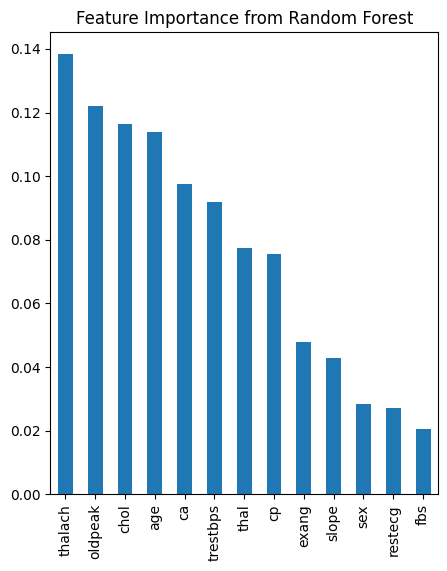

Selected Features via RFE: Index(['cp', 'restecg', 'oldpeak', 'ca', 'thal'], dtype='object')
Chi-Square p-values:
 thal        8.672776e-10
exang       2.083076e-08
ca          2.154659e-07
oldpeak     2.469786e-03
slope       7.147746e-03
cp          8.336977e-02
sex         1.117436e-01
restecg     1.343754e-01
fbs         1.550901e-01
thalach     5.356604e-01
age         8.706545e-01
trestbps    9.605862e-01
chol        9.963506e-01
dtype: float64

Selected features confirmed by at least 2 methods:
       ca  oldpeak  cp  thal  restecg
0    0.0      2.3   1   6.0        2
1    3.0      1.5   4   3.0        2
2    2.0      2.6   4   7.0        2
3    0.0      3.5   3   3.0        0
4    0.0      1.4   2   3.0        2
..   ...      ...  ..   ...      ...
298  0.0      1.2   1   7.0        0
299  2.0      3.4   4   7.0        0
300  1.0      1.2   4   7.0        0
301  1.0      0.0   2   3.0        2
302  0.0      0.0   3   3.0        0

[303 rows x 5 columns]


In [2]:
###Feature Selection###

# Fit Random Forest
rf= RandomForestClassifier(random_state=42)
rf.fit(X_encoded,y)

# Feature importances
importances= pd.Series(rf.feature_importances_, index= X.columns)
importances= importances.sort_values(ascending=False)

# Plot the top features
plt.figure(figsize=(5,6))
importances.plot(kind='bar')
plt.title("Feature Importance from Random Forest")
plt.show()

# Use Logistic Regression as estimator
estimator = LogisticRegression(max_iter=1000)
rfe = RFE(estimator, n_features_to_select=5)
rfe.fit(X_scaled, y)

selected_features = X.columns[rfe.support_]
print("Selected Features via RFE:", selected_features)

# Scale features to 0-1 (required for chi2)
X_scaled_chi = MinMaxScaler().fit_transform(X_encoded)

chi_scores, p_values = chi2(X_scaled_chi, y)
chi_results = pd.Series(p_values, index=X.columns)
chi_results = chi_results.sort_values()
print("Chi-Square p-values:\n",chi_results)

# Select features confirmed by at least 2 methods

# Top 5 features from Random Forest
rf_top = set(importances.index[:5])

# Top 5 features from Chi-Square (smallest p-values)
chi_top = set(chi_results.index[:5])

# Features selected by RFE
rfe_top = set(selected_features)

# Find features confirmed by at least 2 methods
confirmed_features = (rf_top & chi_top) | (rf_top & rfe_top) | (chi_top & rfe_top)

# If not enough features, fall back to RFE-selected
if len(confirmed_features) < 5:
    confirmed_features = rfe_top

top_features = list(confirmed_features)
X_selected = X[top_features]

print("\nSelected features confirmed by at least 2 methods:\n", X_selected)
